# Deep Learning Cancer Detection with CNN Week 3 Project

## Problem to Solve: CNN Cancer Detection 
This project analyzes and applies Convolutional Neural Networks which is one of deep learning algorithms to solve a Kaggle challenge. This CNN algorithm is to identify metastatic cancer in small image patches taken from larger digital pathology scans. It reads in train and test data and applies the deep learning on the data to detect cancer issues.

## Data Source
The data was downloaded from the internet.
https://www.kaggle.com/c/histopathologic-cancer-detection/overview

Data includes: 
A. Label file:
1.ID of each tif file
2.Labels of each tif file
B. Train data
C. Test data 
## Deep Learning Methods Used
CNN: This is a powerful deep learning method to classify cancer based on input.


# Table of Contents:
1. Import depencies or libraries that need to be used in this project
2. EDA step. Read the data from CVS file and Clean up data or reformat data for the purposes of the project
3. EDA step. Display plots for the input data
4. Apply Logistic Regression and display plots
5. Apply Decision Trees and display plots
6. Apply Random Forest and display plots
7. Apply Gradient Boosting Machines (GBM) and display plots
8. Apply Support Vector Machines (SVM) and display plots
9. Conclusions

### 1. Import depencies or libraries that need to be used in this project


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.image as mpimg

# Get the current working directory
current_dir = os.getcwd()
print("Current working directory:", current_dir)

# Path to test and train data
train_dir = os.path.join(current_dir, 'input/histopathologic-cancer-detection/train/')
test_dir = os.path.join(current_dir, 'input/histopathologic-cancer-detection/test/')
print("test_dir: ", train_dir)
print("test_dir: ", test_dir)

# Path to labels
train_labels_path = os.path.join(current_dir, 'input/histopathologic-cancer-detection/train_labels.csv')
print("Path to labels: ", train_labels_path)

DEBUG_VERBOSE = False

Current working directory: /Volumes/WD5TBForMac-1/CU-Boulder-MSCS/Term4/DeepLearning/Week3
test_dir:  /Volumes/WD5TBForMac-1/CU-Boulder-MSCS/Term4/DeepLearning/Week3/input/histopathologic-cancer-detection/train/
test_dir:  /Volumes/WD5TBForMac-1/CU-Boulder-MSCS/Term4/DeepLearning/Week3/input/histopathologic-cancer-detection/test/
Path to labels:  /Volumes/WD5TBForMac-1/CU-Boulder-MSCS/Term4/DeepLearning/Week3/input/histopathologic-cancer-detection/train_labels.csv


### 2. EDA step. Read the data from CVS file and check data to make sure they are qualified.

In [2]:
# Read labels
train_labels = pd.read_csv(train_labels_path)
train_labels['id'] = train_labels['id'].apply(lambda x: x + '.tif')

# Display some sample data
print(train_labels.head())
print(train_labels.describe())
print(train_labels.info())
print(train_labels.isnull().sum())

# Verify all images mentioned in labels exist in train data
missing_images = []
for img_id in train_labels['id']:
    if not os.path.exists(os.path.join(train_dir, img_id)):
        missing_images.append(img_id)
if missing_images:
    print(f"\nCouldnt find image {image_id} in {train_dir}")
else:
    print("\nAll images mentioned in labels exist in train data folder.")

                                             id  label
0  f38a6374c348f90b587e046aac6079959adf3835.tif      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif      1
2  755db6279dae599ebb4d39a9123cce439965282d.tif      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif      0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif      0
               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
id       0
label    0
dtype: int64

All images mentioned in labels exist in train data folder.


Discussions: From the data output, we can see that there are 220025 entires in the data ranging from 0 to 220024.
There is no missing value or column which is good for the training model.
Column id shows id of each entry while column label shows data type. 
All images in labels are found in train data folder which is good.

### 3. EDA step. Display plots for the input data

A. Label Distribution Plot

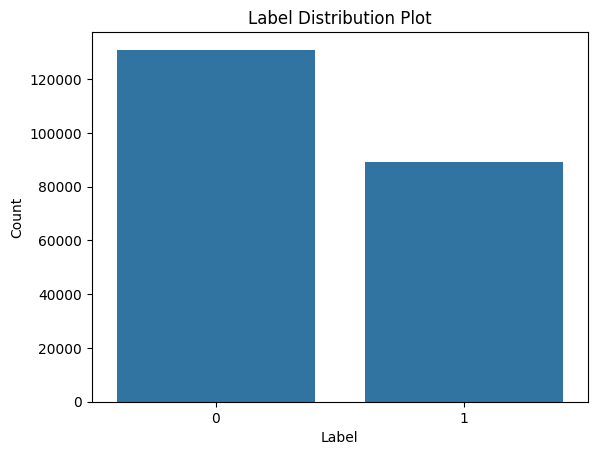

In [3]:
sns.countplot(x='label', data=train_labels)
plt.title('Label Distribution Plot')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()
    

Discussions: The plot above shows cancer(1) vs non-cancer(0) entries in the input data. They are pretty balance, meaning there is significant huge amount of one data type over the other.

B. Show Images from training data input

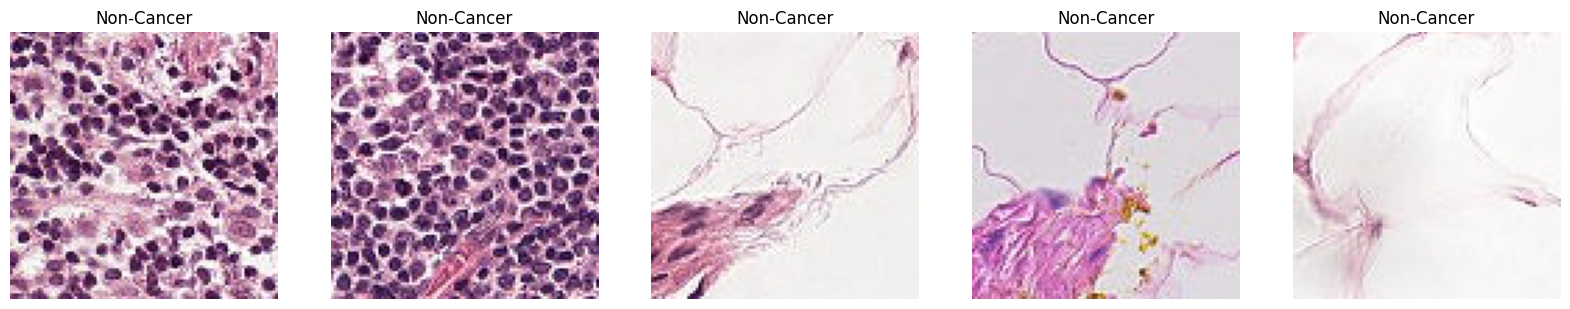

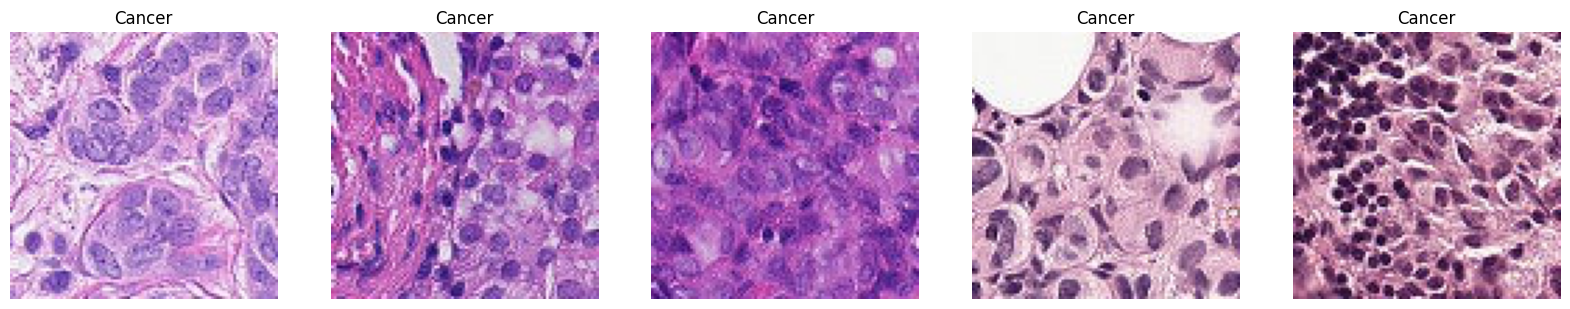

In [4]:
def show_image(df, label, train_dir, sample_size=5):
    sample_images = df[df['label'] == label].sample(sample_size)
    fig, axes = plt.subplots(1, sample_size, figsize=(20, 4))
    for img_id, ax in zip(sample_images['id'], axes):
        img_path = os.path.join(train_dir, img_id)
        img = mpimg.imread(img_path)
        ax.imshow(img)
        if label == 0: 
            ax.set_title(f'{"Non-Cancer"}')
        else:
            ax.set_title(f'{"Cancer"}')            
        ax.axis('off')
    plt.show()
    
# non-cancer
show_image(train_labels, label=0, train_dir=train_dir, sample_size=5)

# cancer
show_image(train_labels, label=1, train_dir=train_dir, sample_size=5)

Discussions: These are images that got pulled from train data.They show different types of cancers vs non-cancers. There is a variety of data which mean the input is  

### 4. Apply CNN and display plots

#### A. Apply CNN on train data 

Plans: Apply the method with params such as:
1/ batch_size = 32 means each iteration will have 32 items
2/ epoch = 20 means the data will go through the training process 20 times
3/ dense and number of neurons mean how many layers and the number of nuerons in each layer.

In [5]:
# convert labels to string to user later
train_labels['label'] = train_labels['label'].astype(str)

# Split data
train_df, val_df = train_test_split(train_labels, test_size=0.2, stratify=train_labels['label'])

datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    validation_split=0.2
)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='id',
    y_col='label',
    subset='training',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_dir,
    x_col='id',
    y_col='label',
    subset='validation',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Train the model
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=[early_stopping]
)


Found 140816 validated image filenames belonging to 2 classes.
Found 8801 validated image filenames belonging to 2 classes.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,370,561 (12.86 MB)

 Trainable params: 3,370,561 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4401/4401 ━━━━━━━━━━━━━━━━━━━━ 3615s 820ms/step - accuracy: 0.7747 - loss: 0.4849 - val_accuracy: 0.8438 - val_loss: 0.3479
Epoch 2/20
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 3813s 865ms/step - accuracy: 0.8466 - loss: 0.3573 - val_accuracy: 0.8622 - val_loss: 0.3192
Epoch 3/20
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 3465s 786ms/step - accuracy: 0.8618 - loss: 0.3281 - val_accuracy: 0.8746 - val_loss: 0.2943
Epoch 4/20
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 3720s 844ms/step - accuracy: 0.8722 - loss: 0.3078 - val_accuracy: 0.8789 - val_loss: 0.2915
Epoch 5/20
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 3538s 803ms/step - accuracy: 0.8791 - loss: 0.2925 - val_accuracy: 0.8866 - val_loss: 0.2684
Epoch 6/20
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 3546s 805ms/step - accuracy: 0.8838 - loss: 0.2859 - val_accuracy: 0.8861 - val_loss: 0.2729
Epoch 7/20
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 3367s 764ms/step - accuracy: 0.8889 - loss: 0.2758 - val_accuracy: 0.8881 - val_loss: 0.2743
Epoch 8/20
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 3695s 838ms/step - accur

2024-06-09 21:34:01.459788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8


   1/4401 ━━━━━━━━━━━━━━━━━━━━ 35:43:31 29s/step - accuracy: 0.9375 - loss: 0.1866

2024-06-09 21:34:15.543598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4401/4401 ━━━━━━━━━━━━━━━━━━━━ 7998s 2s/step - accuracy: 0.9071 - loss: 0.2364 - val_accuracy: 0.9049 - val_loss: 0.2338
Epoch 18/20
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 4084s 926ms/step - accuracy: 0.9077 - loss: 0.2382 - val_accuracy: 0.8900 - val_loss: 0.2752
Epoch 19/20
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 3583s 813ms/step - accuracy: 0.9074 - loss: 0.2363 - val_accuracy: 0.9086 - val_loss: 0.2291
Epoch 20/20
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 3256s 739ms/step - accuracy: 0.9083 - loss: 0.2366 - val_accuracy: 0.9097 - val_loss: 0.2271


#### B. Display plots

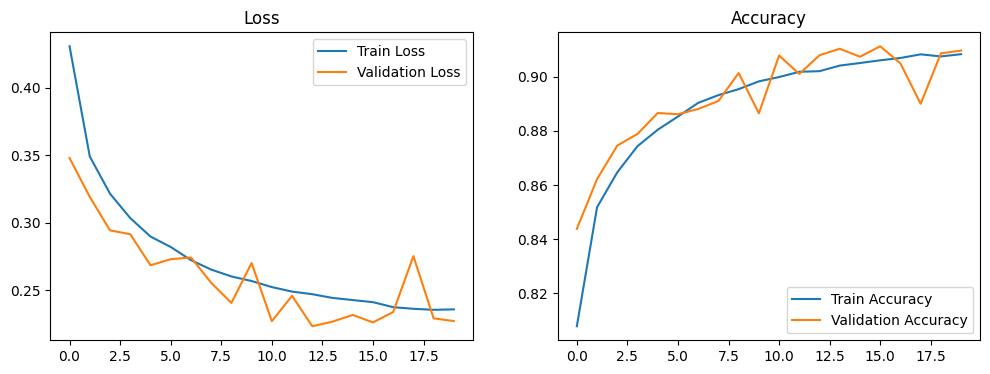

276/276 ━━━━━━━━━━━━━━━━━━━━ 164s 597ms/step - accuracy: 0.9112 - loss: 0.2281
Validation Loss: 0.22950389981269836
Validation Accuracy: 0.9084194898605347


In [6]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Evaluate the model on the validation Loss and Accuracy
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Discussions: As epoch increments, we can see train loss and validation loss decrementing which show the models is being improved.
The train loss and accuracy are reaching their peaks which means they cant be improved much futher.
Validation loss and accuracy are stable but they are up and down which is normal.
For example: The values start at accuracy: 0.7747 - loss: 0.4849 - val_accuracy: 0.8438 - val_loss: 0.3479
At epoch 20th, the values are accuracy: 0.9083 - loss: 0.2366 - val_accuracy: 0.9097 - val_loss: 0.2271

### 5. Tunning and use different parameters to train the model

#### A. Apply CNN with differemtn params

Plans: Apply the method with params such as:
1/ batch_size = 32 means each iteration will have 32 items
2/ epoch = 5 means how many times the data will go back and forth in the training process.
3/ dense and number of neurons mean how many layers and the number of nuerons in each layer are.

In [17]:
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='id',
    y_col='label',
    subset='training',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_dir,
    x_col='id',
    y_col='label',
    subset='validation',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_gen,
    epochs=5,
    validation_data=val_gen,
    callbacks=[early_stopping, model_checkpoint]
)


Found 140816 validated image filenames belonging to 2 classes.
Found 8801 validated image filenames belonging to 2 classes.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       819,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 913,473 (3.48 MB)

 Trainable params: 913,025 (3.48 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4401/4401 ━━━━━━━━━━━━━━━━━━━━ 7349s 2s/step - accuracy: 0.7873 - loss: 0.7180 - val_accuracy: 0.8416 - val_loss: 0.5436
Epoch 2/5


2024-06-10 21:17:15.330948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:56: Filling up shuffle buffer (this may take a while): 6 of 8


   1/4401 ━━━━━━━━━━━━━━━━━━━━ 17:28:03 14s/step - accuracy: 0.8438 - loss: 0.5925

2024-06-10 21:17:18.127637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4401/4401 ━━━━━━━━━━━━━━━━━━━━ 8746s 2s/step - accuracy: 0.8356 - loss: 0.5391 - val_accuracy: 0.7988 - val_loss: 0.6246
Epoch 3/5


2024-06-10 23:43:01.528275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:56: Filling up shuffle buffer (this may take a while): 3 of 8
2024-06-10 23:43:08.437091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4401/4401 ━━━━━━━━━━━━━━━━━━━━ 8638s 2s/step - accuracy: 0.8528 - loss: 0.4545 - val_accuracy: 0.8639 - val_loss: 0.4067
Epoch 4/5


2024-06-11 02:06:58.166470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:56: Filling up shuffle buffer (this may take a while): 5 of 8
2024-06-11 02:07:01.453845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


4401/4401 ━━━━━━━━━━━━━━━━━━━━ 4598s 1s/step - accuracy: 0.8691 - loss: 0.4099 - val_accuracy: 0.8229 - val_loss: 0.4883
Epoch 5/5
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 4202s 954ms/step - accuracy: 0.8773 - loss: 0.3834 - val_accuracy: 0.8623 - val_loss: 0.3950


#### B. Display Plots

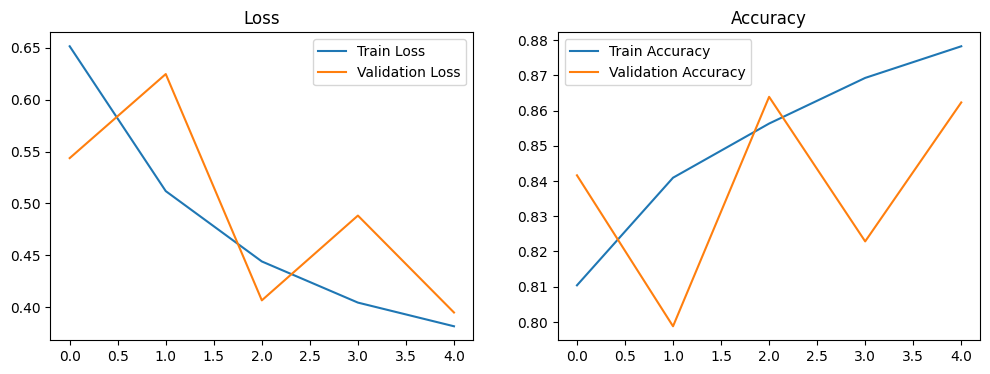

276/276 ━━━━━━━━━━━━━━━━━━━━ 259s 941ms/step - accuracy: 0.8574 - loss: 0.3982
Validation Loss: 0.3958684504032135
Validation Accuracy: 0.859220564365387


In [18]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Evaluate the model on the validation Loss and Accuracy
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Discussions: As epoch increments, we can see train loss and validation loss decrementing which show the models is being improved. The train loss and accuracy are reaching their peaks which means they cant be improved much futher. Validation loss and accuracy are stable but they are up and down which is normal. For example: accuracy: 0.7873 - loss: 0.7180 - val_accuracy: 0.8416 - val_loss: 0.5436 At epoch 5th, the values are accuracy: accuracy: 0.8773 - loss: 0.3834 - val_accuracy: 0.8623 - val_loss: 0.3950

### 6. Apply CNN on the test data


In [26]:
#### A. Use the latest model for test data

In [20]:
# load the best model out of all all models
best_model = load_model('best_model.keras')

test_image_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith('.tif')]
test_df = pd.DataFrame({
    'id': [os.path.basename(fname) for fname in test_image_paths],
    'filepath': test_image_paths
})

# data generator
test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col=None,
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# predictions
predictions = best_model.predict(test_gen)
predicted_labels = (predictions > 0.5).astype(int).ravel()

# submissions
submission = pd.DataFrame({
    'id': [os.path.splitext(fname)[0] for fname in test_gen.filenames],
    'label': predicted_labels
})

submission_file = os.path.join(current_dir, 'submission.csv')
submission.to_csv(submission_file, index=False)
print(f"Saving submission to: {submission_file}")

Found 57458 validated image filenames.
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 57s 32ms/step
Saving submission to: /Volumes/WD5TBForMac-1/CU-Boulder-MSCS/Term4/DeepLearning/Week3/submission.csv


In [ ]:
#### B. Display plots

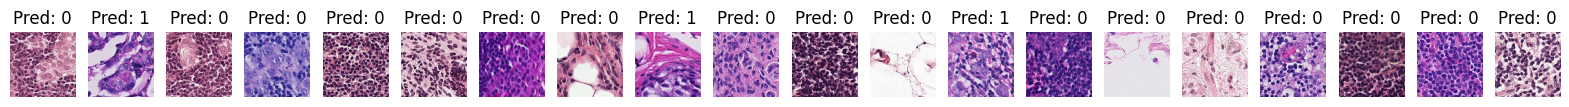

In [23]:
# Plotting some sample images with predictions
def show_test_results(test_gen, predictions, sample_size=10):
    fig, axes = plt.subplots(1, sample_size, figsize=(20, 5))
    for img_path, prediction, ax in zip(test_gen.filepaths[:sample_size], predictions[:sample_size], axes):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(f'Pred: {prediction}')
        ax.axis('off')
    plt.show()

# show sample predictions
show_test_results(test_gen, predicted_labels, sample_size=20)

Discussions: From trainng with test data used the same model that yields the best results. The results show cancerous vs non cancerous pictures.

### 7. Conclusions

In conclusion, the first model yields the best results because it has more epoch and more dense in each layer; therefore, the data goes through a lot iterations which improves accuracy and reduces loss. 
Validation Loss: 0.22950389981269836
Validation Accuracy: 0.9084194898605347
The results seem to be impressive. 
The loss and result diagrams show the significant trendlines at the begining and they also dont change much at the end. This means the model had peaked and couldnt be improve much more.
What I could improve was incrementing buffer size so some of the training didn't need to shuffle which may alter the results.
